In [54]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [55]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [56]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [57]:
data = read_text("rus.txt")
rus_eng = to_lines(data)
rus_eng = array(rus_eng)

In [101]:
rus_eng = rus_eng[:5000,:]

In [102]:
rus_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in rus_eng[:,0]]
rus_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in rus_eng[:,1]]

rus_eng

array([['go', 'марш',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)'],
       ['go', 'иди',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)'],
       ['go', 'идите',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)'],
       ...,
       ['she is nice', 'она хорошая',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2252433 (CM) & #2079280 (marafon)'],
       ['she is nice', 'она славная',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2252433 (CM) & #3585875 (sharptoothed)'],
       ['she slipped', 'она поскользнулась',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3233875 (CM) & #3136258 (marafon)']],
      dtype='<U537')

In [103]:
for i in range(len(rus_eng)):
    rus_eng[i,0] = rus_eng[i,0].lower()
    rus_eng[i,1] = rus_eng[i,1].lower()

rus_eng

array([['go', 'марш',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)'],
       ['go', 'иди',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)'],
       ['go', 'идите',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)'],
       ...,
       ['she is nice', 'она хорошая',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2252433 (CM) & #2079280 (marafon)'],
       ['she is nice', 'она славная',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2252433 (CM) & #3585875 (sharptoothed)'],
       ['she slipped', 'она поскользнулась',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3233875 (CM) & #3136258 (marafon)']],
      dtype='<U537')

C:\Users\silly\AppData\Roaming\Python\Python38\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


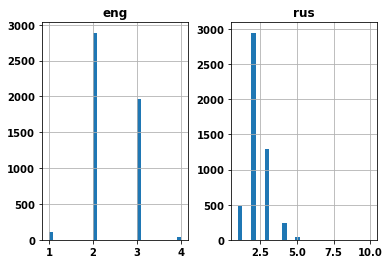

In [104]:
eng_l = []
rus_l = []

# populate the lists with sentence lengths
for i in rus_eng[:,0]:
      eng_l.append(len(i.split()))

for i in rus_eng[:,1]:
      rus_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'rus':rus_l})

length_df.hist(bins = 30)
plt.show()

In [105]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [106]:
rus_eng[:,1]

array(['марш', 'иди', 'идите', ..., 'она хорошая', 'она славная',
       'она поскользнулась'], dtype='<U537')

In [107]:
# prepare english tokenizer
eng_tokenizer = tokenization(rus_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 1105


In [108]:
# prepare Deutch tokenizer
rus_tokenizer = tokenization(rus_eng[:, 1])
rus_vocab_size = len(rus_tokenizer.word_index) + 1

rus_length = 8
print('Russian Vocabulary Size: %d' % rus_vocab_size)

Russian Vocabulary Size: 2848


In [109]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [110]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(rus_eng, test_size=0.2)

In [111]:
# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [112]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [146]:
# model compilation
from tensorflow.keras import optimizers
model = define_model(rus_vocab_size, eng_vocab_size, rus_length, eng_length, 512)
#rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                    metrics=["accuracy"])

In [157]:
#filename = 'model.h1.24_sep_16'
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# model.save("s2", save_format="h5")
# train model

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    batch_size=32,
                    epochs=50,
                    validation_split=0.3)
                    #callbacks=[checkpoint],
                    #verbose=1)
#epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
#                    verbose=1)
# Save model
model.save("s2_2", save_format="h5")

Epoch 1/50
88/88 [==============================] - 180s 496ms/step - loss: 0.1371 - accuracy: 0.9613 - val_loss: 0.9041 - val_accuracy: 0.8701
Epoch 2/50
88/88 [==============================] - 36s 411ms/step - loss: 0.1143 - accuracy: 0.9685 - val_loss: 0.9254 - val_accuracy: 0.8673
Epoch 3/50
88/88 [==============================] - 35s 401ms/step - loss: 0.1003 - accuracy: 0.9712 - val_loss: 0.9394 - val_accuracy: 0.8667
Epoch 4/50
88/88 [==============================] - 34s 382ms/step - loss: 0.0893 - accuracy: 0.9717 - val_loss: 0.9479 - val_accuracy: 0.8640
Epoch 5/50
88/88 [==============================] - 35s 393ms/step - loss: 0.0788 - accuracy: 0.9744 - val_loss: 0.9665 - val_accuracy: 0.8621
Epoch 6/50
88/88 [==============================] - 37s 417ms/step - loss: 0.0724 - accuracy: 0.9752 - val_loss: 0.9691 - val_accuracy: 0.8651
Epoch 7/50
88/88 [==============================] - 35s 399ms/step - loss: 0.0666 - accuracy: 0.9751 - val_loss: 0.9807 - val_accuracy: 0.864

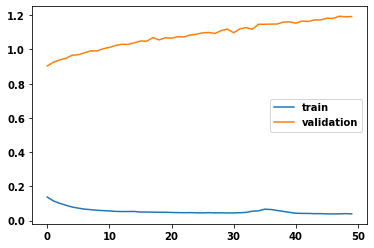

In [158]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [159]:
model = load_model('s2_2')
#preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
#np.argmax(model.predict(x), axis=-1)
predict_x=model.predict(testX.reshape((testX.shape[0],testX.shape[1]))) 
classes_x=argmax(predict_x, axis = -1)

In [121]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [160]:
preds_text = []
for i in classes_x:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))


In [175]:
def predict(word):
    preds_text = []
    for i in classes_x:
        temp = []
        for j in range(len(i)):
            t = word
            if j > 0:
                if (t == word) or (t == None):
                    temp.append('')
                else:
                    temp.append(t)
            else:
                if(t == None):
                    temp.append('')
                else:
                    temp.append(t) 

    preds_text.append(' '.join(temp))
    return preds_text

In [153]:
test

array([['i hate milk', 'я ненавижу молоко',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3177296 (Theocracy) & #3689623 (Selena777)'],
       ['do come in', 'входи же',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2245265 (CK) & #5891027 (marafon)'],
       ['i came back', 'я вернулась',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2245637 (CK) & #2732466 (afyodor)'],
       ...,
       ['be ruthless', 'будьте беспощадны',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2111957 (CK) & #3294738 (marafon)'],
       ['keep that', 'оставь это себе',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2111634 (CK) & #2771283 (marafon)'],
       ['look again', 'посмотрите ещё раз',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2111614 (CK) & #5048197 (marafon)']],
      dtype='<U537')

In [182]:
pred_df_1 = pd.DataFrame({'input rus': test[:,1],'actual eng' : test[:,0], 'predicted eng' : preds_text })

In [163]:
pred_df_1.sample(15)

,input rus,actual eng,predicted eng
914,прекратите это,cut it out,stop that
578,я не буду плакать,i wont cry,im not
954,я навеселе,im tipsy,im am
108,рассчитывай на меня,count on me,marry me
347,будьте безжалостны,be ruthless,be punctual
77,понятно,i see,get out
968,том свободен,toms free,tom snores
50,я бы это сделал,id do that,id buy it
461,у меня дети,i have kids,i have time
229,можно ли мне начать,can i begin,can i begin


In [166]:

pred_df.sample(15)

,input rus,actual eng,predicted eng
910,вы пытались,you tried,you tried
259,я его закопал,i buried it,i said it
87,я спасла тебя,i saved you,i know you
663,я её закопал,i buried it,i could it
793,давай попробуем,lets try,lets try
388,оно мне нужно,i need it,i need it
191,я спросил почему,i asked why,i work well
430,у него есть вино,he has wine,i have eat
845,мне хочется пить,im thirsty,im thirsty
397,одно синее,one is blue,what we


In [179]:
from nltk.translate.bleu_score import corpus_bleu
references = pred_df_1['actual']
candidates = pred_df_1['predicted']
score = corpus_bleu(references, candidates)
print('{:.5f}'.format(score))
print(score)

0.00000
1.4168066944670677e-231


In [180]:
from nltk.translate.bleu_score import corpus_bleu
references = pred_df['actual']
candidates = pred_df['predicted']
score = corpus_bleu(references, candidates)
print('{:.5f}'.format(score))
print(score)

0.00000
3.899510617627667e-232


In [168]:
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 8, 512)            1458176   
_________________________________________________________________
lstm_22 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 8, 512)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 8, 512)            2099200   
_________________________________________________________________
dense_11 (Dense)             (None, 8, 1105)           566865    
Total params: 6,223,441
Trainable params: 6,223,441
Non-trainable params: 0
_________________________________________________________________
None
